In [68]:
# Imports nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from wordcloud import WordCloud
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import os

# Configuration du random_state
rand_st = 42


In [69]:
# Chargement et préparation des données
data = pd.read_csv("wdbc.data", header=None)

# Mise en place des noms de colonnes
noms_colonnes = ['ID', 'Diagnostique']
NomsSans_ = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension']
NomsAvec_ = []
for e in NomsSans_:
    NomsAvec_.append(e+'_mean')
    NomsAvec_.append(e+'_se')
    NomsAvec_.append(e+'_worst')

for f in NomsAvec_:
    noms_colonnes.append(f)

data.columns = noms_colonnes

# Transformation de la variable Diagnostique en binaire
def diag_to_bin(letter):
    if letter=="M":
        return 1
    else:
        return 0
    
diag_bin = data["Diagnostique"].apply(diag_to_bin)
data["Diagnostique"] = diag_bin

print("Description de la Base de données : ")
print(data.describe())


Description de la Base de données : 
                 ID  Diagnostique  radius_mean   radius_se  radius_worst  \
count  5.690000e+02    569.000000   569.000000  569.000000    569.000000   
mean   3.037183e+07      0.372583    14.127292   19.289649     91.969033   
std    1.250206e+08      0.483918     3.524049    4.301036     24.298981   
min    8.670000e+03      0.000000     6.981000    9.710000     43.790000   
25%    8.692180e+05      0.000000    11.700000   16.170000     75.170000   
50%    9.060240e+05      0.000000    13.370000   18.840000     86.240000   
75%    8.813129e+06      1.000000    15.780000   21.800000    104.100000   
max    9.113205e+08      1.000000    28.110000   39.280000    188.500000   

       texture_mean  texture_se  texture_worst  perimeter_mean  perimeter_se  \
count    569.000000  569.000000     569.000000      569.000000    569.000000   
mean     654.889104    0.096360       0.104341        0.088799      0.048919   
std      351.914129    0.014064       

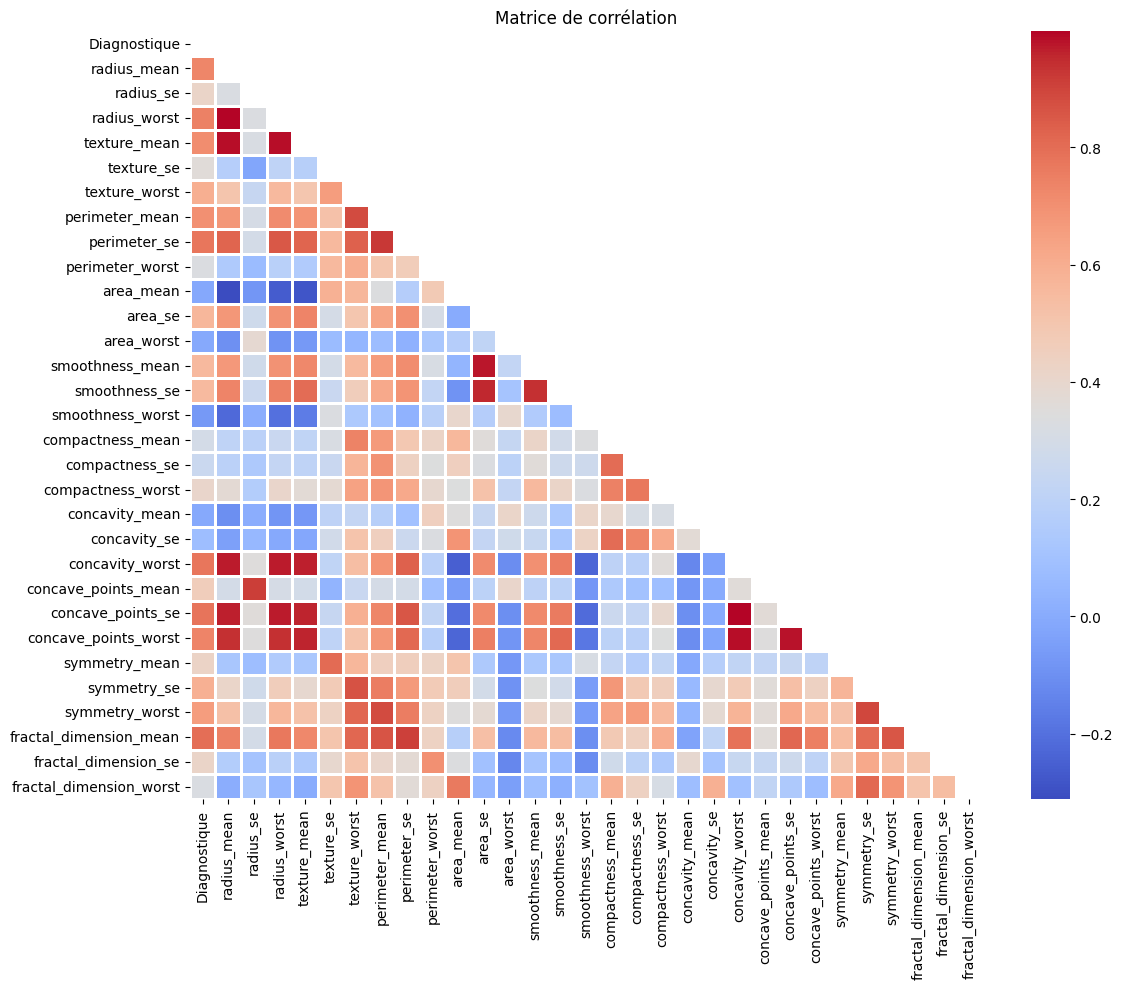

In [70]:
# Visualisation : Matrice de corrélation
data_sans_id = data.drop(["ID"], axis=1)
Matrice_Corr = data_sans_id.corr()
masque = np.triu(Matrice_Corr)

plt.figure(figsize=(12, 10))
sns.heatmap(Matrice_Corr, annot=False, linewidths=1, cmap='coolwarm', mask=masque)
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.savefig('code_PCA_LDA_correlation_matrix.png')
plt.show()


In [71]:
# Analyse PCA : Réduction de dimensions
y = data_sans_id["Diagnostique"]
X = data_sans_id.drop("Diagnostique", axis=1)
X_sd = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X_sd)

# Calcul des valeurs propres
print("Valeurs propres :")
print(pca.explained_variance_)

# Part de variance expliquée
print("")
print("Part de variance expliquée par composante :")
print(pca.explained_variance_ / pca.explained_variance_.sum())
print("")
print("Variance expliquée cumulative :")
print((pca.explained_variance_ / pca.explained_variance_.sum()).cumsum())


Valeurs propres :
[1.33049908e+01 5.70137460e+00 2.82291016e+00 1.98412752e+00
 1.65163324e+00 1.20948224e+00 6.76408882e-01 4.77456255e-01
 4.17628782e-01 3.51310875e-01 2.94433153e-01 2.61621161e-01
 2.41782421e-01 1.57286149e-01 9.43006956e-02 8.00034045e-02
 5.95036135e-02 5.27114222e-02 4.95647002e-02 3.12142606e-02
 3.00256631e-02 2.74877113e-02 2.43836914e-02 1.80867940e-02
 1.55085271e-02 8.19203712e-03 6.91261258e-03 1.59213600e-03
 7.50121413e-04 1.33279057e-04]

Part de variance expliquée par composante :
[4.42720256e-01 1.89711820e-01 9.39316326e-02 6.60213492e-02
 5.49576849e-02 4.02452204e-02 2.25073371e-02 1.58872380e-02
 1.38964937e-02 1.16897819e-02 9.79718988e-03 8.70537901e-03
 8.04524987e-03 5.23365745e-03 3.13783217e-03 2.66209337e-03
 1.97996793e-03 1.75395945e-03 1.64925306e-03 1.03864675e-03
 9.99096464e-04 9.14646751e-04 8.11361259e-04 6.01833567e-04
 5.16042379e-04 2.72587995e-04 2.30015463e-04 5.29779290e-05
 2.49601032e-05 4.43482743e-06]

Variance expliquée

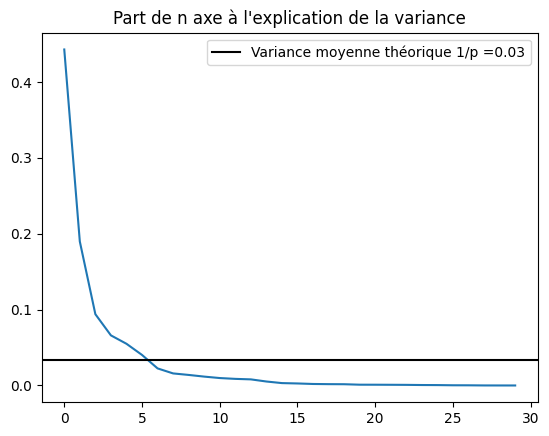

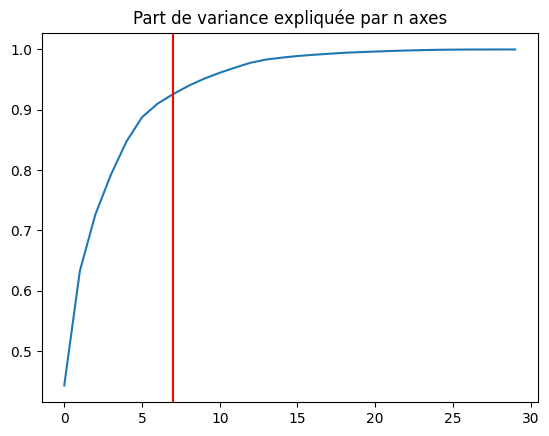

In [72]:
# Visualisation de la variance expliquée
plt.plot(pca.explained_variance_ / pca.explained_variance_.sum())
plt.axhline(1 / X_sd.shape[1], color='k', label="Variance moyenne théorique 1/p ="+str(np.round((1 / X_sd.shape[1]), decimals=2)))
plt.title("Part de n axe à l'explication de la variance")
plt.legend()
plt.savefig('Part de n axe à l explication de la variance.png')
plt.show()

nb_dim_opti = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(nb_dim_opti, color='r', label="Nombre d'axe optimal pour expliquer 90% de la variance (="+str(nb_dim_opti)+")")
plt.title("Part de variance expliquée par n axes")
plt.savefig('Part de variance expliquée par n axes')
plt.show()


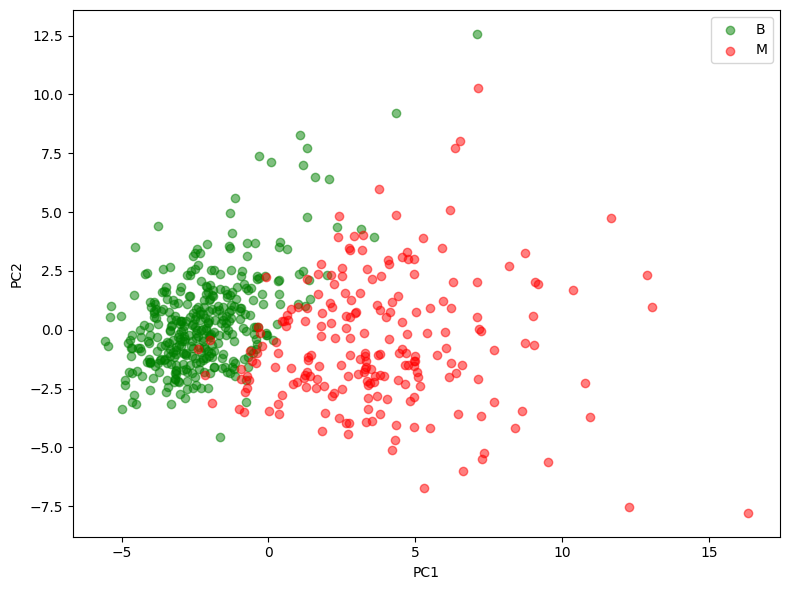

In [73]:
# Projection des patients sur les axes PC1 et PC2
X_pca = pca.transform(X_sd)

mask_malignant = (y == 1)
mask_benign = (y == 0)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[mask_benign, 0], X_pca[mask_benign, 1], color='green', alpha=0.5, label='B')
plt.scatter(X_pca[mask_malignant, 0], X_pca[mask_malignant, 1], color='red', alpha=0.5, label='M')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig("Projection des patients sur le plan des deux premiers axes PCA.png")
plt.show()


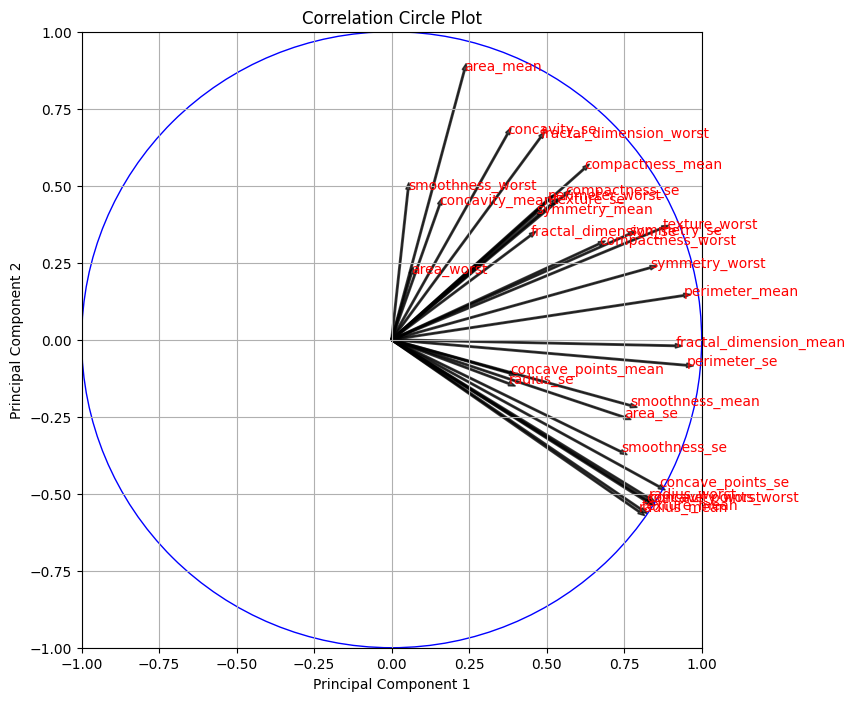

In [74]:
# Cercle des corrélations PC1-PC2
PC = pca.components_.T * np.sqrt(pca.explained_variance_)
PC_df = pd.DataFrame(PC, index=X.columns)

plt.figure(figsize=(8, 8))
plt.title('Correlation Circle Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

for i in range(0, X.shape[1]):
    plt.arrow(0, 0, PC[i, 0], PC[i, 1], color='black', alpha=0.7, width=0.005)

feature = X.columns
for i in range(0, X.shape[1]):
    plt.annotate(feature[i], (PC[i, 0], PC[i, 1]), color='red')

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True)
plt.gca().add_artist(plt.Circle((0, 0), 1, color='blue', fill=False))
plt.savefig('Correlation Circle Plot axe 1&2.png')
plt.show()


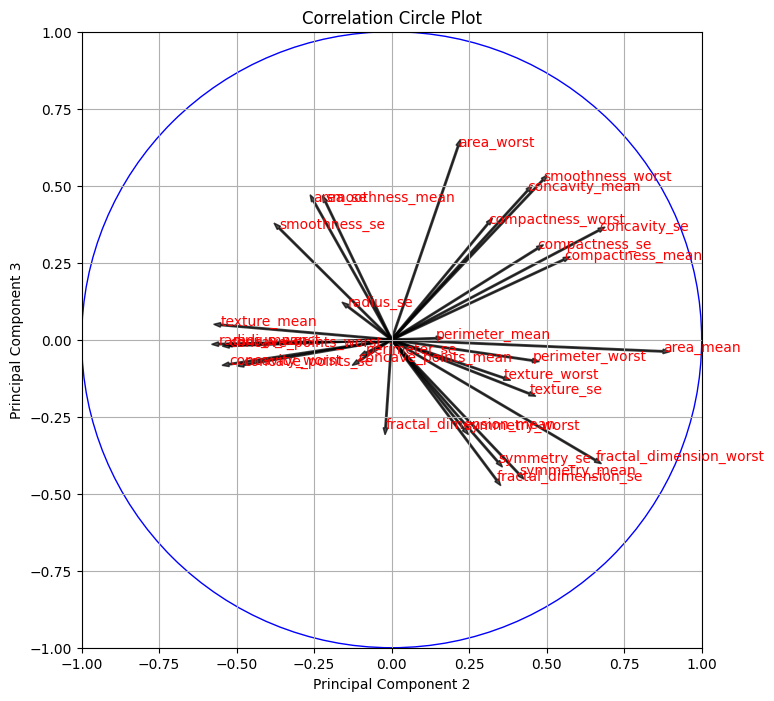

In [75]:
# Cercle des corrélations PC2-PC3
plt.figure(figsize=(8, 8))
plt.title('Correlation Circle Plot')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')

for i in range(0, X.shape[1]):
    plt.arrow(0, 0, PC[i, 1], PC[i, 2], color='black', alpha=0.7, width=0.005)

feature = X.columns
for i in range(0, X.shape[1]):
    plt.annotate(feature[i], (PC[i, 1], PC[i, 2]), color='red')

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True)
plt.gca().add_artist(plt.Circle((0, 0), 1, color='blue', fill=False))
plt.savefig('Correlation Circle Plot axe 2&3.png')
plt.show()


In [76]:
# Fonction d'évaluation des modèles
def evaluation_modele(model, X_train, X_test, y_train, y_test, override="yes", w=0.8):
    if hasattr(model, 'predict_proba'):
        y_test_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_test_proba, drop_intermediate=False)
        roc_auc = roc_auc_score(y_test, y_test_proba)
        
        if override.lower() == "yes":
            youden_index = w*tpr - (1-w)*fpr
            youden_type = "pondéré"
        else:
            youden_index = tpr - fpr
            youden_type = "standard"
        
        optimal_idx = np.argmax(youden_index)
        optimal_threshold = thresholds[optimal_idx]
        
        y_test_pred = (y_test_proba >= optimal_threshold).astype(int)
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_train_pred = (y_train_proba >= optimal_threshold).astype(int)
        
        recall_optimal = recall_score(y_test, y_test_pred)
        
        print("Seuil optimal de Youden (" + youden_type + "): " + str(np.round(optimal_threshold, 4)))
        print("Recall obtenu avec ce seuil: " + str(np.round(recall_optimal, 4)))
    else:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
    train_score = accuracy_score(y_train, y_train_pred)
    test_score = accuracy_score(y_test, y_test_pred)

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    print(model)
    print(conf_matrix)
    
    print(classification_report(y_test, y_test_pred, target_names=['Benign', 'Malignant']))
    
    return {'train_score': train_score, 'test_score': test_score, 'confusion_matrix': conf_matrix, 'model': model}

results = {}


In [77]:
# Préparation des données pour l'entraînement des modèles
y = data_sans_id["Diagnostique"]
X = data_sans_id.drop("Diagnostique", axis=1)
X_sd = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_sd, y, test_size=0.2, random_state=rand_st, stratify=y, shuffle=True)


In [78]:
# Modèles de base : LDA, QDA, Régression Logistique, KNN, Random Forest
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train, y_train)
results['LDA'] = evaluation_modele(lda, X_train, X_test, y_train, y_test)


Seuil optimal de Youden (pondéré): 0.0587
Recall obtenu avec ce seuil: 1.0
LinearDiscriminantAnalysis()
[[66  6]
 [ 0 42]]
              precision    recall  f1-score   support

      Benign       1.00      0.92      0.96        72
   Malignant       0.88      1.00      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.96      0.94       114
weighted avg       0.95      0.95      0.95       114



In [79]:
# QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
results['QDA'] = evaluation_modele(qda, X_train, X_test, y_train, y_test)


Seuil optimal de Youden (pondéré): 0.0002
Recall obtenu avec ce seuil: 1.0
QuadraticDiscriminantAnalysis()
[[64  8]
 [ 0 42]]
              precision    recall  f1-score   support

      Benign       1.00      0.89      0.94        72
   Malignant       0.84      1.00      0.91        42

    accuracy                           0.93       114
   macro avg       0.92      0.94      0.93       114
weighted avg       0.94      0.93      0.93       114



In [80]:
# Régression Logistique simple
logit = LogisticRegression(max_iter=2000, random_state=rand_st, class_weight='balanced')
logit.fit(X_train, y_train)
results['Logistic Regression'] = evaluation_modele(logit, X_train, X_test, y_train, y_test)


Seuil optimal de Youden (pondéré): 0.2742
Recall obtenu avec ce seuil: 0.9762
LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
[[69  3]
 [ 1 41]]
              precision    recall  f1-score   support

      Benign       0.99      0.96      0.97        72
   Malignant       0.93      0.98      0.95        42

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



In [81]:
# KNN avec GridSearch
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 20, 25]}
knn_base = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_base, param_grid_knn, cv=5, scoring='recall', n_jobs=-1, verbose=1)
knn_grid.fit(X_train, y_train)
print("Meilleur k: " + str(knn_grid.best_params_['n_neighbors']))
print("Score validation croisée: " + str(knn_grid.best_score_))
results['KNN'] = evaluation_modele(knn_grid.best_estimator_, X_train, X_test, y_train, y_test)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Meilleur k: 3
Score validation croisée: 0.9294117647058824
Seuil optimal de Youden (pondéré): 0.3333
Recall obtenu avec ce seuil: 0.9762
KNeighborsClassifier(n_neighbors=3)
[[68  4]
 [ 1 41]]
              precision    recall  f1-score   support

      Benign       0.99      0.94      0.96        72
   Malignant       0.91      0.98      0.94        42

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



In [82]:
# Random Forest avec optimisation des hyperparamètres
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
rf_base = RandomForestClassifier(random_state=rand_st, n_jobs=-1, class_weight='balanced')
rf_grid = GridSearchCV(rf_base, param_grid_rf, cv=5, scoring='recall', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
print("Meilleurs hyperparamètres: " + str(rf_grid.best_params_))
print("Score validation croisée: " + str(rf_grid.best_score_))
results['Random Forest'] = evaluation_modele(rf_grid.best_estimator_, X_train, X_test, y_train, y_test)

# Stockage des features_importance du Random Forest
features_importance_rf = dict(zip(X.columns, rf_grid.best_estimator_.feature_importances_))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Meilleurs hyperparamètres: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Score validation croisée: 0.9470588235294117
Seuil optimal de Youden (pondéré): 0.2301
Recall obtenu avec ce seuil: 1.0
RandomForestClassifier(class_weight='balanced', max_features='log2',
                       min_samples_leaf=2, n_jobs=-1, random_state=42)
[[70  2]
 [ 0 42]]
              precision    recall  f1-score   support

      Benign       1.00      0.97      0.99        72
   Malignant       0.95      1.00      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.99      0.98       114
weighted avg       0.98      0.98      0.98       114



In [83]:
# Régression logistique avec réseau de neurones et early stopping
# Préparation des données
def split_data_nn(X, y):
    X_train_full, X_test_nn, y_train_full, y_test_nn = train_test_split(
        X, y, test_size=0.20, random_state=rand_st, shuffle=True, stratify=y
    )
    X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(
        X_train_full, y_train_full, test_size=0.125, random_state=rand_st, shuffle=True, stratify=y_train_full
    )
    return X_test_nn, y_test_nn, X_train_nn, y_train_nn, X_valid_nn, y_valid_nn

# Utiliser les données sans ID et sans standardisation (sera fait dans le preprocessing)
X_features_nn = data_sans_id.drop("Diagnostique", axis=1)
y_nn = data_sans_id["Diagnostique"]

X_test_nn, y_test_nn, X_train_nn, y_train_nn, X_valid_nn, y_valid_nn = split_data_nn(X_features_nn, y_nn)

def preprocess_data_nn(X_train, X_valid, X_test):
    """Standardise les données pour améliorer la convergence"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_valid_scaled, X_test_scaled, scaler

print("Préparation des données pour le neural network...")
X_train_np = X_train_nn.to_numpy().astype(np.float32)
X_valid_np = X_valid_nn.to_numpy().astype(np.float32)
X_test_np = X_test_nn.to_numpy().astype(np.float32)

y_train_np = y_train_nn.to_numpy().astype(np.float32).reshape(-1, 1)
y_valid_np = y_valid_nn.to_numpy().astype(np.float32).reshape(-1, 1)
y_test_np = y_test_nn.to_numpy().astype(np.float32).reshape(-1, 1)

X_train_scaled_nn, X_valid_scaled_nn, X_test_scaled_nn, scaler_nn = preprocess_data_nn(
    X_train_np, X_valid_np, X_test_np
)

print("Shapes - Train: " + str(X_train_scaled_nn.shape) + ", Valid: " + str(X_valid_scaled_nn.shape) + ", Test: " + str(X_test_scaled_nn.shape))


Préparation des données pour le neural network...
Shapes - Train: (398, 30), Valid: (57, 30), Test: (114, 30)


Construction du modèle...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Début de l'entraînement...
Epoch 1/200
13/13 [==============================] - 2s 72ms/step - loss: 1.0579 - recall: 0.1879 - val_loss: 0.9697 - val_recall: 0.2857
Epoch 2/200
 1/13 [=>............................] - ETA: 0s - loss: 0.9731 - recall: 0.2727

c:\Users\valen\anaconda3\envs\py38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 0s 29ms/step - loss: 0.9592 - recall: 0.2617 - val_loss: 0.8764 - val_recall: 0.3810
Epoch 3/200
13/13 [==============================] - 0s 19ms/step - loss: 0.8708 - recall: 0.3289 - val_loss: 0.7955 - val_recall: 0.3810
Epoch 4/200
13/13 [==============================] - 0s 15ms/step - loss: 0.7957 - recall: 0.3893 - val_loss: 0.7242 - val_recall: 0.4286
Epoch 5/200
13/13 [==============================] - 0s 10ms/step - loss: 0.7295 - recall: 0.4564 - val_loss: 0.6625 - val_recall: 0.5714
Epoch 6/200
13/13 [==============================] - 0s 10ms/step - loss: 0.6736 - recall: 0.5302 - val_loss: 0.6082 - val_recall: 0.5714
Epoch 7/200
13/13 [==============================] - 0s 15ms/step - loss: 0.6253 - recall: 0.5839 - val_loss: 0.5611 - val_recall: 0.5714
Epoch 8/200
13/13 [==============================] - 0s 12ms/step - loss: 0.5820 - recall: 0.6376 - val_loss: 0.5217 - val_recall: 0.6190
Epoch 9/200
13/13 [===========================

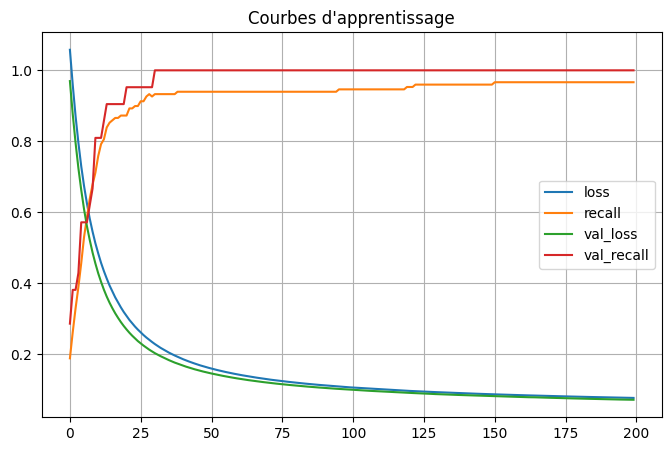

In [84]:
# Construction et entraînement du modèle
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

def build_logistic_regression(X, learning_rate=0.001):
    """
    Construit un modèle de régression logistique avec Keras.
    X : jeu de données d'entraînement (pour déterminer le nombre de features)
    learning_rate : taux d'apprentissage de l'optimiseur Adam
    """
    model = Sequential()
    
    # Couche unique : régression logistique
    model.add(Dense(1, input_dim=X.shape[1], activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[tf.keras.metrics.Recall(name='recall')]
    )
    
    model.summary()
    return model

def train_model_nn(model, X_train, X_valid, y_train, y_valid, model_name="Logit_model.h5"):
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        model_name,
        save_best_only=True
    )
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        patience=20,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=200,
        validation_data=(X_valid, y_valid),
        callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
        verbose=1
    )
    
    learning_curves = pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.title("Courbes d'apprentissage")
    plt.grid(True)
    plt.show()
    
    return history, learning_curves

print("Construction du modèle...")
model_nn = build_logistic_regression(X_train_scaled_nn)

print("Début de l'entraînement...")
history_nn, learning_curves_nn = train_model_nn(
    model_nn, X_train_scaled_nn, X_valid_scaled_nn, y_train_np, y_valid_np
)


In [85]:
# Évaluation et stockage des résultats
print("Évaluation sur le test set...")
eval_results = model_nn.evaluate(X_test_scaled_nn, y_test_np, verbose=0)
print("Résultats sur le test set - Loss: " + str(round(eval_results[0], 4)) + ", Recall: " + str(round(eval_results[1], 4)))

# Charger le meilleur modèle sauvegardé
model_nn_best = keras.models.load_model("Logit_model.h5")
y_proba_nn = model_nn_best.predict(X_test_scaled_nn)

# Stocker les résultats dans le dictionnaire results
results['Logistic Regression NN'] = {
    'model': model_nn_best,
    'y_proba': y_proba_nn.flatten(),
    'y_test': y_test_nn
}

# Extraction des coefficients (poids)
weights, bias = model_nn_best.layers[0].get_weights()
coef_df_nn = pd.DataFrame({
    "Feature": X_features_nn.columns,
    "Coefficient": weights.flatten()
})
coef_df_nn["Odds_Ratio"] = np.exp(coef_df_nn["Coefficient"])

print("")
print("Coefficients du modèle Neural Network:")
print(coef_df_nn.head(10))


Évaluation sur le test set...
Résultats sur le test set - Loss: 0.0822, Recall: 0.9524
4/4 [==============================] - 0s 7ms/step

Coefficients du modèle Neural Network:
           Feature  Coefficient  Odds_Ratio
0      radius_mean     0.321337    1.378970
1        radius_se     0.679016    1.971935
2     radius_worst     0.130489    1.139385
3     texture_mean     0.923319    2.517633
4       texture_se     0.518273    1.679126
5    texture_worst     0.308868    1.361883
6   perimeter_mean     0.679971    1.973820
7     perimeter_se     0.204886    1.227385
8  perimeter_worst     0.106946    1.112875
9        area_mean    -0.590570    0.554012


In [86]:
# Régression logistique avec réseau de neurones et NearMiss
# Préparation des données avec NearMiss
X_features_nn_nm = data_sans_id.drop("Diagnostique", axis=1)
y_nn_nm = data_sans_id["Diagnostique"]

def split_data_nn_nm(X, y):
    X_train_full, X_test_nn_nm, y_train_full, y_test_nn_nm = train_test_split(
        X, y, test_size=0.20, random_state=rand_st, shuffle=True, stratify=y
    )
    X_train_nn_nm, X_valid_nn_nm, y_train_nn_nm, y_valid_nn_nm = train_test_split(
        X_train_full, y_train_full, test_size=0.125, random_state=rand_st, shuffle=True, stratify=y_train_full
    )
    # Application de NearMiss sur les données d'entraînement
    nm = NearMiss(version=1)
    X_train_nn_nm, y_train_nn_nm = nm.fit_resample(X_train_nn_nm, y_train_nn_nm)
    return X_test_nn_nm, y_test_nn_nm, X_train_nn_nm, y_train_nn_nm, X_valid_nn_nm, y_valid_nn_nm

X_test_nn_nm, y_test_nn_nm, X_train_nn_nm, y_train_nn_nm, X_valid_nn_nm, y_valid_nn_nm = split_data_nn_nm(X_features_nn_nm, y_nn_nm)

print("Préparation des données avec NearMiss...")
X_train_np_nm = X_train_nn_nm.to_numpy().astype(np.float32)
X_valid_np_nm = X_valid_nn_nm.to_numpy().astype(np.float32)
X_test_np_nm = X_test_nn_nm.to_numpy().astype(np.float32)

y_train_np_nm = y_train_nn_nm.to_numpy().astype(np.float32).reshape(-1, 1)
y_valid_np_nm = y_valid_nn_nm.to_numpy().astype(np.float32).reshape(-1, 1)
y_test_np_nm = y_test_nn_nm.to_numpy().astype(np.float32).reshape(-1, 1)

X_train_scaled_nn_nm, X_valid_scaled_nn_nm, X_test_scaled_nn_nm, scaler_nn_nm = preprocess_data_nn(
    X_train_np_nm, X_valid_np_nm, X_test_np_nm
)

print("Shapes après NearMiss - Train: " + str(X_train_scaled_nn_nm.shape) + ", Valid: " + str(X_valid_scaled_nn_nm.shape) + ", Test: " + str(X_test_scaled_nn_nm.shape))


Préparation des données avec NearMiss...
Shapes après NearMiss - Train: (298, 30), Valid: (57, 30), Test: (114, 30)


Construction du modèle avec NearMiss...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Début de l'entraînement avec NearMiss...
Epoch 1/200
10/10 [==============================] - 2s 80ms/step - loss: 0.9163 - recall: 0.4295 - val_loss: 0.8692 - val_recall: 0.2381
Epoch 2/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.8389 - recall: 0.5000

c:\Users\valen\anaconda3\envs\py38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 28ms/step - loss: 0.8363 - recall: 0.5034 - val_loss: 0.7878 - val_recall: 0.3810
Epoch 3/200
10/10 [==============================] - 0s 30ms/step - loss: 0.7665 - recall: 0.5436 - val_loss: 0.7158 - val_recall: 0.4762
Epoch 4/200
10/10 [==============================] - 0s 50ms/step - loss: 0.7028 - recall: 0.5772 - val_loss: 0.6519 - val_recall: 0.5238
Epoch 5/200
10/10 [==============================] - 0s 27ms/step - loss: 0.6484 - recall: 0.6040 - val_loss: 0.5959 - val_recall: 0.4762
Epoch 6/200
10/10 [==============================] - 0s 38ms/step - loss: 0.5985 - recall: 0.6174 - val_loss: 0.5478 - val_recall: 0.6667
Epoch 7/200
10/10 [==============================] - 0s 29ms/step - loss: 0.5591 - recall: 0.6644 - val_loss: 0.5042 - val_recall: 0.7143
Epoch 8/200
10/10 [==============================] - 0s 31ms/step - loss: 0.5213 - recall: 0.6779 - val_loss: 0.4674 - val_recall: 0.7619
Epoch 9/200
10/10 [===========================

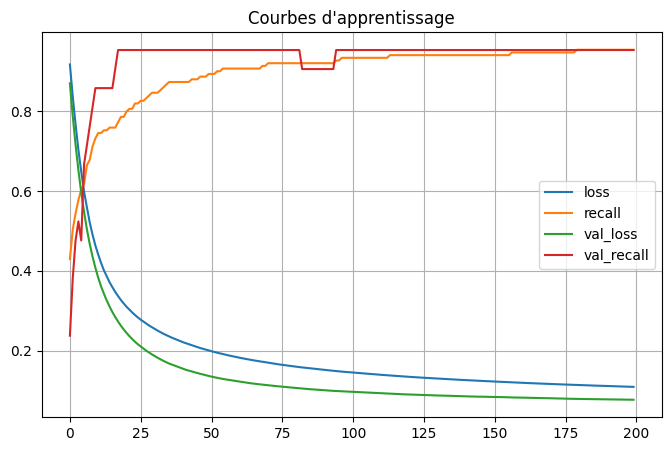

In [87]:
# Construction et entraînement du modèle avec NearMiss
run_logdir_nm = get_run_logdir()
tensorboard_cb_nm = tf.keras.callbacks.TensorBoard(run_logdir_nm)

print("Construction du modèle avec NearMiss...")
model_nn_nm = build_logistic_regression(X_train_scaled_nn_nm)

print("Début de l'entraînement avec NearMiss...")
history_nn_nm, learning_curves_nn_nm = train_model_nn(
    model_nn_nm, X_train_scaled_nn_nm, X_valid_scaled_nn_nm, y_train_np_nm, y_valid_np_nm, "Logit_model_NM.h5"
)


In [88]:
# Évaluation du modèle avec NearMiss
print("Évaluation sur le test set...")
eval_results_nm = model_nn_nm.evaluate(X_test_scaled_nn_nm, y_test_np_nm, verbose=0)
print("Résultats sur le test set - Loss: " + str(round(eval_results_nm[0], 4)) + ", Recall: " + str(round(eval_results_nm[1], 4)))

# Charger le meilleur modèle sauvegardé
model_nn_nm_best = keras.models.load_model("Logit_model_NM.h5")
y_proba_nn_nm = model_nn_nm_best.predict(X_test_scaled_nn_nm)

# Stocker les résultats
results['Logistic Regression NN NearMiss'] = {
    'model': model_nn_nm_best,
    'y_proba': y_proba_nn_nm.flatten(),
    'y_test': y_test_nn_nm
}

print("")
print("Modèle avec NearMiss ajouté aux résultats")


Évaluation sur le test set...
Résultats sur le test set - Loss: 0.1017, Recall: 0.9286
4/4 [==============================] - 0s 7ms/step

Modèle avec NearMiss ajouté aux résultats


In [89]:
# Régression Logistique avancée : Baseline, NearMiss, SMOTE
# Préparation des données (sans standardisation car fait dans le pipeline)
X_features = data_sans_id.drop("Diagnostique", axis=1)
y_logit = data_sans_id["Diagnostique"]
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(
    X_features, y_logit, test_size=0.2, random_state=rand_st, shuffle=True, stratify=y_logit
)

param_grid_logit = [
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']},
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['liblinear', 'saga']},
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['saga'], 'l1_ratio': [0, 0.5, 1]},
    {'penalty': [None], 'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'saga']}
]


In [90]:
# Logistique Baseline
baseline_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=rand_st, max_iter=9000))
])

baseline_param_grid = []
for params in param_grid_logit:
    pipeline_params = {}
    for key, value in params.items():
        pipeline_params[f'model__{key}'] = value
    baseline_param_grid.append(pipeline_params)

baseline_grid_search = GridSearchCV(
    estimator=baseline_pipeline,
    param_grid=baseline_param_grid,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

baseline_grid_search.fit(X_train_logit, y_train_logit.values.ravel())
print("Meilleurs hyperparamètres (Baseline):", baseline_grid_search.best_params_)
print("Meilleure accuracy moyenne (CV): " + str(round(baseline_grid_search.best_score_, 4)))

baseline_model = baseline_grid_search.best_estimator_
baseline_y_proba = baseline_model.predict_proba(X_test_logit)[:, 1]
results['Logit_Baseline'] = {'model': baseline_model, 'y_proba': baseline_y_proba}


Fitting 5 folds for each of 49 candidates, totalling 245 fits
Meilleurs hyperparamètres (Baseline): {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'sag'}
Meilleure accuracy moyenne (CV): 0.9736


In [91]:
# Logistique avec NearMiss
NM_Pipeline = ImbPipeline([
    ('sampling', NearMiss(version=1, n_jobs=-1)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=rand_st, max_iter=9000))
])

NM_param_grid = []
for params in param_grid_logit:
    pipeline_params = {}
    for key, value in params.items():
        pipeline_params[f'model__{key}'] = value
    NM_param_grid.append(pipeline_params)

NM_grid_search = GridSearchCV(
    estimator=NM_Pipeline,
    param_grid=NM_param_grid,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

NM_grid_search.fit(X_train_logit, y_train_logit.values.ravel())
print("Meilleurs hyperparamètres (NearMiss):", NM_grid_search.best_params_)
print("Meilleure accuracy moyenne (CV): " + str(round(NM_grid_search.best_score_, 4)))

NM_model = NM_grid_search.best_estimator_
NM_y_proba = NM_model.predict_proba(X_test_logit)[:, 1]
results['Logit_NearMiss'] = {'model': NM_model, 'y_proba': NM_y_proba}


Fitting 5 folds for each of 49 candidates, totalling 245 fits
Meilleurs hyperparamètres (NearMiss): {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Meilleure accuracy moyenne (CV): 0.978


In [92]:
# Logistique avec SMOTE
smote_pipeline = ImbPipeline([
    ('sampling', SMOTE(random_state=rand_st, n_jobs=-1)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=rand_st, max_iter=9000))
])

smote_param_grid = []
for params in param_grid_logit:
    for k in [2, 5, 8, 10]:
        pipeline_params = {}
        for key, value in params.items():
            pipeline_params[f'model__{key}'] = value
        pipeline_params['sampling__k_neighbors'] = [k]
        smote_param_grid.append(pipeline_params)

smote_grid_search = GridSearchCV(
    estimator=smote_pipeline,
    param_grid=smote_param_grid,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

smote_grid_search.fit(X_train_logit, y_train_logit.values.ravel())
print("Meilleurs hyperparamètres (SMOTE):", smote_grid_search.best_params_)
print("Meilleure accuracy moyenne (CV): " + str(round(smote_grid_search.best_score_, 4)))

smote_model = smote_grid_search.best_estimator_
smote_y_proba = smote_model.predict_proba(X_test_logit)[:, 1]
results['Logit_SMOTE'] = {'model': smote_model, 'y_proba': smote_y_proba}


Fitting 5 folds for each of 196 candidates, totalling 980 fits
Meilleurs hyperparamètres (SMOTE): {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'sampling__k_neighbors': 8}
Meilleure accuracy moyenne (CV): 0.9802


c:\Users\valen\anaconda3\envs\py38\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [93]:
# Régression Logistique avec PCA : Baseline, NearMiss, SMOTE
X_features_pca = data_sans_id.drop("Diagnostique", axis=1)
y_pca = data_sans_id["Diagnostique"]
X_train_pca_logit, X_test_pca_logit, y_train_pca_logit, y_test_pca_logit = train_test_split(
    X_features_pca, y_pca, test_size=0.2, random_state=rand_st, shuffle=True, stratify=y_pca
)

baseline_pca_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('dim-red', PCA()),
    ('model', LogisticRegression(random_state=rand_st, max_iter=9000))
])

baseline_pca_param_grid = []
for params in param_grid_logit:
    for i in range(0, 12):
        pipeline_params = {}
        for key, value in params.items():
            pipeline_params[f'model__{key}'] = value
        pipeline_params["dim-red__n_components"] = [i]
        baseline_pca_param_grid.append(pipeline_params)

baseline_pca_grid_search = GridSearchCV(
    estimator=baseline_pca_pipeline,
    param_grid=baseline_pca_param_grid,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

baseline_pca_grid_search.fit(X_train_pca_logit, y_train_pca_logit.values.ravel())
print("Meilleurs hyperparamètres (PCA Baseline):", baseline_pca_grid_search.best_params_)
print("Meilleure accuracy moyenne (CV): " + str(round(baseline_pca_grid_search.best_score_, 4)))

baseline_pca_model = baseline_pca_grid_search.best_estimator_
baseline_pca_y_proba = baseline_pca_model.predict_proba(X_test_pca_logit)[:, 1]
results['PCALogit_Baseline'] = {'model': baseline_pca_model, 'y_proba': baseline_pca_y_proba}


Fitting 5 folds for each of 588 candidates, totalling 2940 fits


Meilleurs hyperparamètres (PCA Baseline): {'dim-red__n_components': 10, 'model__C': 1, 'model__penalty': 'l1', 'model__solver': 'saga'}
Meilleure accuracy moyenne (CV): 0.9802


c:\Users\valen\anaconda3\envs\py38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
245 fits failed out of a total of 2940.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
245 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\valen\anaconda3\envs\py38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\valen\anaconda3\envs\py38\lib\site-packages\imblearn\utils\fixes.py", line 85, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\valen\anaconda3\envs\py38\lib\site-packages\imblearn\pipeline.py", line 333, in fit
    self._final_estimator.fi

In [94]:
# Logistique PCA avec NearMiss
NM_pca_pipeline = ImbPipeline([
    ('sampling', NearMiss(version=1, n_jobs=-1)),
    ('scaler', StandardScaler()),
    ('dim-red', PCA()),
    ('model', LogisticRegression(random_state=rand_st, max_iter=9000))
])

NM_pca_param_grid = []
for params in param_grid_logit:
    for i in range(1, 12):
        pipeline_params = {}
        for key, value in params.items():
            pipeline_params[f'model__{key}'] = value
        pipeline_params["dim-red__n_components"] = [i]
        NM_pca_param_grid.append(pipeline_params)

NM_pca_grid_search = GridSearchCV(
    estimator=NM_pca_pipeline,
    param_grid=NM_pca_param_grid,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

NM_pca_grid_search.fit(X_train_pca_logit, y_train_pca_logit.values.ravel())
print("Meilleurs hyperparamètres (PCA NearMiss):", NM_pca_grid_search.best_params_)
print("Meilleure accuracy moyenne (CV): " + str(round(NM_pca_grid_search.best_score_, 4)))

NM_pca_model = NM_pca_grid_search.best_estimator_
NM_pca_y_proba = NM_pca_model.predict_proba(X_test_pca_logit)[:, 1]
results['PCALogit_NearMiss'] = {'model': NM_pca_model, 'y_proba': NM_pca_y_proba}


Fitting 5 folds for each of 539 candidates, totalling 2695 fits
Meilleurs hyperparamètres (PCA NearMiss): {'dim-red__n_components': 9, 'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Meilleure accuracy moyenne (CV): 0.978


In [95]:
# Logistique PCA avec SMOTE
smote_pca_pipeline = ImbPipeline([
    ('sampling', SMOTE(random_state=rand_st, n_jobs=-1)),
    ('scaler', StandardScaler()),
    ('dim-red', PCA()),
    ('model', LogisticRegression(random_state=rand_st, max_iter=9000))
])

smote_pca_param_grid = []
for params in param_grid_logit:
    for k in [2, 5, 8, 10]:
        for i in range(1, 12):
            pipeline_params = {}
            for key, value in params.items():
                pipeline_params[f'model__{key}'] = value
            pipeline_params["dim-red__n_components"] = [i]
            pipeline_params['sampling__k_neighbors'] = [k]
            smote_pca_param_grid.append(pipeline_params)

smote_pca_grid_search = GridSearchCV(
    estimator=smote_pca_pipeline,
    param_grid=smote_pca_param_grid,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

smote_pca_grid_search.fit(X_train_pca_logit, y_train_pca_logit.values.ravel())
print("Meilleurs hyperparamètres (PCA SMOTE):", smote_pca_grid_search.best_params_)
print("Meilleure accuracy moyenne (CV): " + str(round(smote_pca_grid_search.best_score_, 4)))

smote_pca_model = smote_pca_grid_search.best_estimator_
smote_pca_y_proba = smote_pca_model.predict_proba(X_test_pca_logit)[:, 1]
results['PCALogit_SMOTE'] = {'model': smote_pca_model, 'y_proba': smote_pca_y_proba}


Fitting 5 folds for each of 2156 candidates, totalling 10780 fits
Meilleurs hyperparamètres (PCA SMOTE): {'dim-red__n_components': 9, 'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'sampling__k_neighbors': 5}
Meilleure accuracy moyenne (CV): 0.9802


c:\Users\valen\anaconda3\envs\py38\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


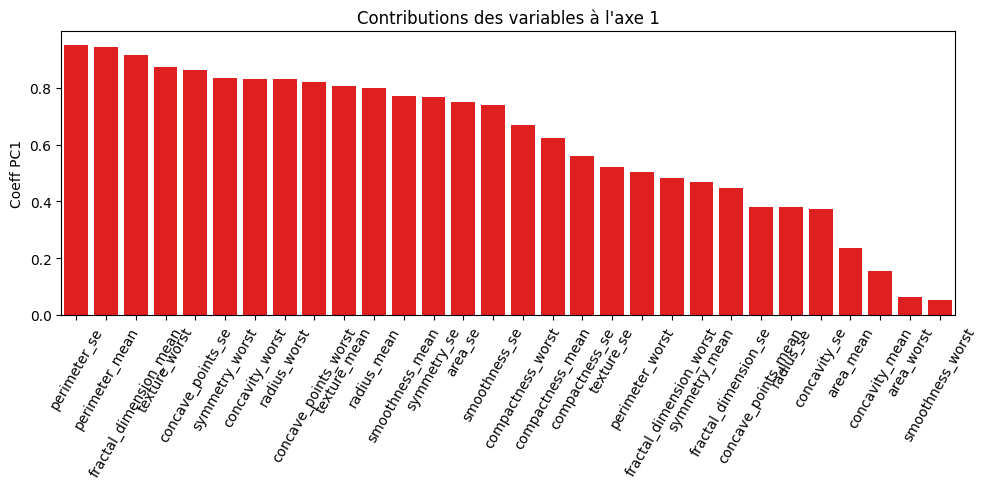

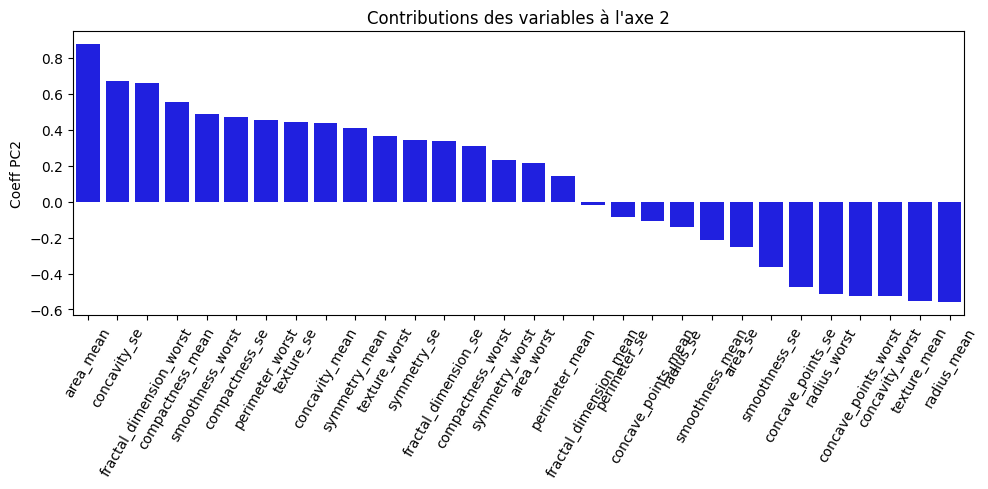

In [96]:
# Modèle Logistique avec PCA (version Code_Modeles_Val.py)
# Test de la Régression Logistique sur un nombre n variable d'axes de la PCA
X_features_val = data_sans_id.drop("Diagnostique", axis=1)
y_val = data_sans_id["Diagnostique"]

X_sd_val = StandardScaler().fit_transform(X_features_val)
pca_val = PCA()
pca_val.fit(X_sd_val)

# Graphique des coefficients PCA
PC_val = pca_val.components_.T * np.sqrt(pca_val.explained_variance_)
PC_df_val = pd.DataFrame(PC_val[:, :2], index=X_features_val.columns, columns=['PC1', 'PC2'])

PC1_sorted = PC_df_val['PC1'].sort_values(ascending=False)
PC2_sorted = PC_df_val['PC2'].sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=PC1_sorted.index, y=PC1_sorted.values, color='red')
plt.xticks(rotation=60)
plt.title("Contributions des variables à l'axe 1")
plt.ylabel("Coeff PC1")
plt.tight_layout()
plt.savefig("Contributions des variables à l'axe 1.png")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=PC2_sorted.index, y=PC2_sorted.values, color='blue')
plt.xticks(rotation=60)
plt.title("Contributions des variables à l'axe 2")
plt.ylabel("Coeff PC2")
plt.tight_layout()
plt.savefig("Contributions des variables à l'axe 2.png")
plt.show()


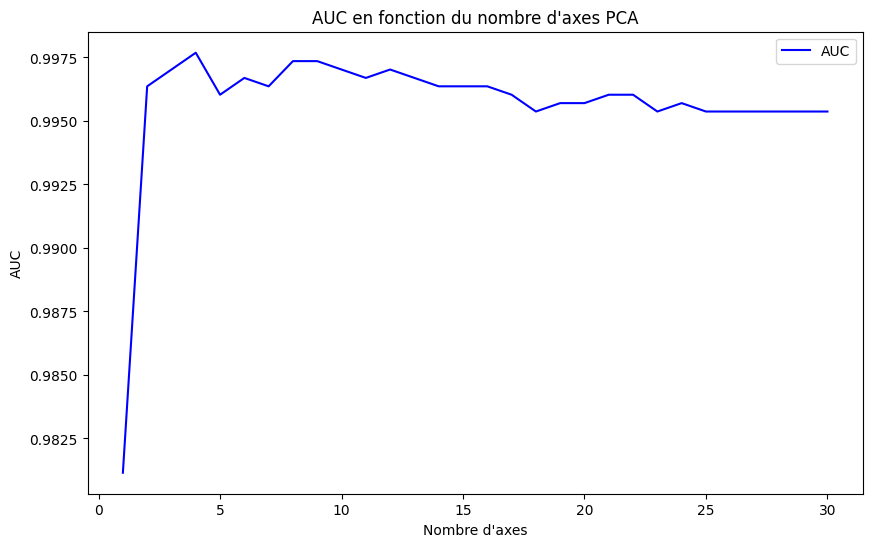

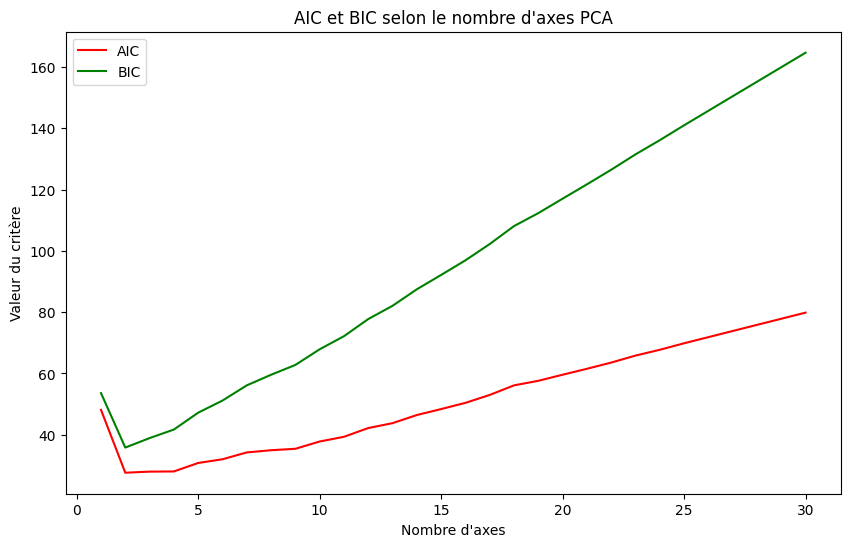

In [97]:
# Test de la Régression Logistique sur différents nombres d'axes PCA
X_pca_val = pca_val.transform(X_sd_val)
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(
    X_pca_val, y_val, test_size=0.2, random_state=rand_st, stratify=y_val
)

nb_components = X_pca_val.shape[1]
range_compon = range(1, nb_components + 1)

auc_list = []
aic_list = []
bic_list = []

n = X_test_val.shape[0]

for n_components in range_compon:
    X_train_pca = X_train_val[:, :n_components]
    X_test_pca = X_test_val[:, :n_components]

    logit = LogisticRegression(max_iter=2000, random_state=rand_st, class_weight='balanced')
    logit.fit(X_train_pca, y_train_val)
    
    y_pred_proba = logit.predict_proba(X_test_pca)[:, 1]
    auc_score = roc_auc_score(y_test_val, y_pred_proba)
    
    L = -log_loss(y_test_val, y_pred_proba, normalize=False)
    k = n_components + 1
    aic = 2*k - 2*L
    bic = np.log(n)*k - 2*L

    auc_list.append(auc_score)
    aic_list.append(aic)
    bic_list.append(bic)

plt.figure(figsize=(10, 6))
plt.plot(range_compon, auc_list, label='AUC', color='blue')
plt.title("AUC en fonction du nombre d'axes PCA")
plt.xlabel("Nombre d'axes")
plt.ylabel("AUC")
plt.legend()
plt.savefig("AUC en fonction du nombre d'axes PCA.png")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_compon, aic_list, label='AIC', color='red')
plt.plot(range_compon, bic_list, label='BIC', color='green')
plt.title("AIC et BIC selon le nombre d'axes PCA")
plt.xlabel("Nombre d'axes")
plt.ylabel("Valeur du critère")
plt.legend()
plt.savefig("AIC et BIC selon le nombre d'axes PCA.png")
plt.show()


In [98]:
# Évaluation du modèle Logistique sur 5 axes PCA
X_train_pca5 = X_train_val[:, :5]
X_test_pca5 = X_test_val[:, :5]

logit_pca5 = LogisticRegression(max_iter=2000, random_state=rand_st, class_weight='balanced')
logit_pca5.fit(X_train_pca5, y_train_val)

y_proba_pca5 = logit_pca5.predict_proba(X_test_pca5)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_val, y_proba_pca5, drop_intermediate=False)
roc_auc_pca5 = roc_auc_score(y_test_val, y_proba_pca5)

youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

y_pred_thr = (y_proba_pca5 >= optimal_threshold).astype(int)

cm = confusion_matrix(y_test_val, y_pred_thr)
recall = recall_score(y_test_val, y_pred_thr)
precision = precision_score(y_test_val, y_pred_thr)

print("Matrice de confusion avec seuil optimal de Youden (t="+str(np.round(optimal_threshold, 4))+"): ", cm)

res_logit_pca5 = evaluation_modele(logit_pca5, X_train_pca5, X_test_pca5, y_train_val, y_test_val)

auc_pca5 = roc_auc_score(y_test_val, y_proba_pca5)
print("AUC pour n=5 axes : " + str(np.round(auc_pca5, 3)))


Matrice de confusion avec seuil optimal de Youden (t=0.6875):  [[72  0]
 [ 2 40]]
Seuil optimal de Youden (pondéré): 0.1221
Recall obtenu avec ce seuil: 1.0
LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
[[65  7]
 [ 0 42]]
              precision    recall  f1-score   support

      Benign       1.00      0.90      0.95        72
   Malignant       0.86      1.00      0.92        42

    accuracy                           0.94       114
   macro avg       0.93      0.95      0.94       114
weighted avg       0.95      0.94      0.94       114

AUC pour n=5 axes : 0.996


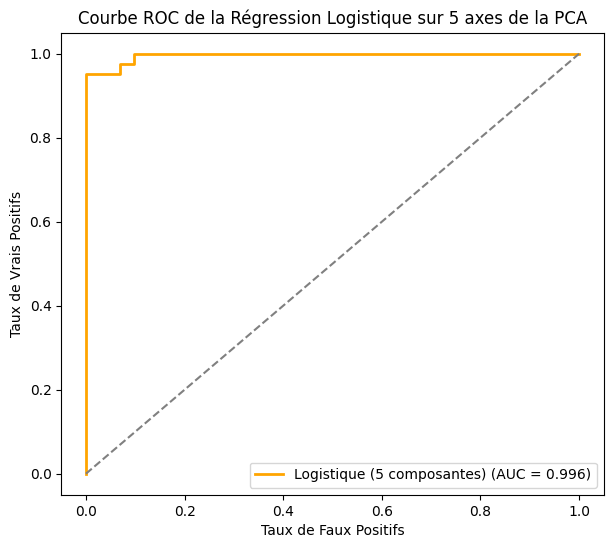

Logistique PCA (5 comp): Accuracy=0.9684+-0.0042, ROC-AUC=0.9941+-0.0044


In [99]:
# Courbe ROC pour le modèle Logistique avec 5 axes PCA
fpr, tpr, thresholds = roc_curve(y_test_val, y_proba_pca5)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label='Logistique (5 composantes) (AUC = '+str(np.round(auc_pca5, 3))+')')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.title("Courbe ROC de la Régression Logistique sur 5 axes de la PCA")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.legend()
plt.savefig("Courbe ROC de la Régression Logistique sur 5 axes de la PCA.png")
plt.show()

# Validation croisée pour le modèle logistique avec PCA
pipeline_pca_logit = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('logit', LogisticRegression(max_iter=2000, random_state=rand_st, class_weight='balanced'))
])
acc_cv = cross_val_score(pipeline_pca_logit, X_features_val, y_val, cv=5, scoring='accuracy', n_jobs=-1)
roc_cv = cross_val_score(pipeline_pca_logit, X_features_val, y_val, cv=5, scoring=make_scorer(roc_auc_score, needs_proba=True), n_jobs=-1)
print("Logistique PCA (5 comp): Accuracy=" + str(round(acc_cv.mean(), 4)) + "+-" + str(round(acc_cv.std(), 4)) + ", ROC-AUC=" + str(round(roc_cv.mean(), 4)) + "+-" + str(round(roc_cv.std(), 4)))


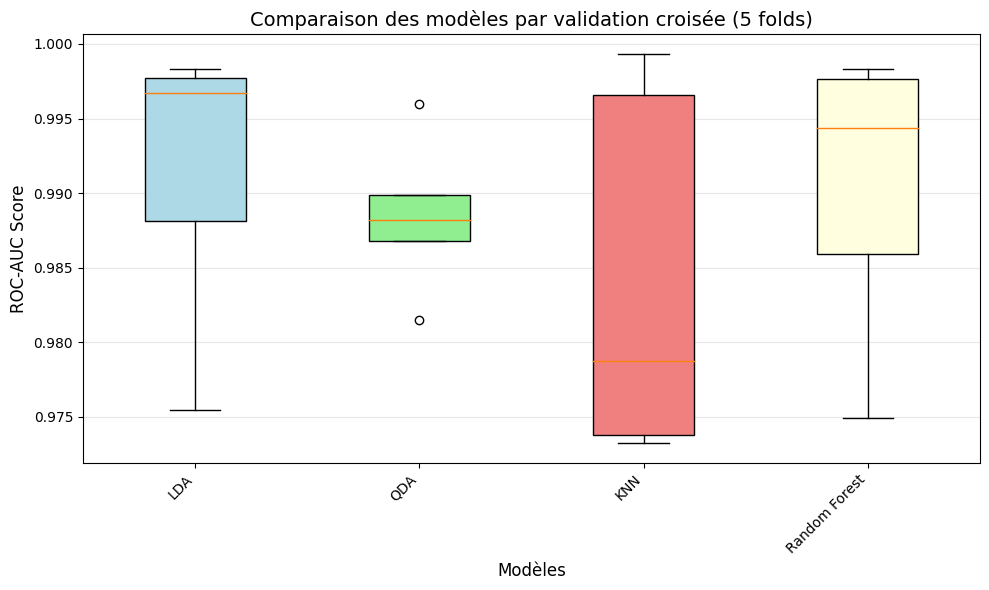


Statistiques des scores ROC-AUC (validation croisée):
LDA: Mean=0.9913, Std=0.0087, Min=0.9754, Max=0.9983
QDA: Mean=0.9885, Std=0.0047, Min=0.9815, Max=0.996
KNN: Mean=0.9843, Std=0.0113, Min=0.9732, Max=0.9993
Random Forest: Mean=0.9902, Std=0.0088, Min=0.9749, Max=0.9983


In [111]:
# Boxplot de comparaison des modèles
# Modèles à comparer (ceux de la courbe ROC)
models_to_compare = ['LDA', 'QDA', 'KNN', 'Random Forest', 'Logistic Regression NN']

# Préparer les données pour le boxplot
boxplot_data = []
boxplot_labels = []

# Ajouter les modèles avec validation croisée
try:
    if 'cv_scores_roc' in globals() and len(cv_scores_roc) > 0:
        for model_name in models_to_compare:
            if model_name in cv_scores_roc:
                boxplot_data.append(cv_scores_roc[model_name])
                boxplot_labels.append(model_name)
except:
    pass

# Vérifier qu'il y a des données avant de créer le boxplot
if len(boxplot_data) == 0:
    print("Avertissement: Aucune donnée disponible pour le boxplot.")
    print("Veuillez exécuter la cellule de validation croisée (cellule précédente) avant cette cellule.")
else:
    # Créer le boxplot
    plt.figure(figsize=(10, 6))
    bp = plt.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True)

    # Colorier les boxplots
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)

    plt.ylabel('ROC-AUC Score', fontsize=12)
    plt.xlabel('Modèles', fontsize=12)
    plt.title('Comparaison des modèles par validation croisée (5 folds)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('Boxplot_comparaison_modeles.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Afficher les statistiques
    print("")
    print("Statistiques des scores ROC-AUC (validation croisée):")
    for model_name in models_to_compare:
        if model_name in cv_scores_roc:
            scores = cv_scores_roc[model_name]
            print(model_name + ": Mean=" + str(round(scores.mean(), 4)) + ", Std=" + str(round(scores.std(), 4)) + ", Min=" + str(round(scores.min(), 4)) + ", Max=" + str(round(scores.max(), 4)))


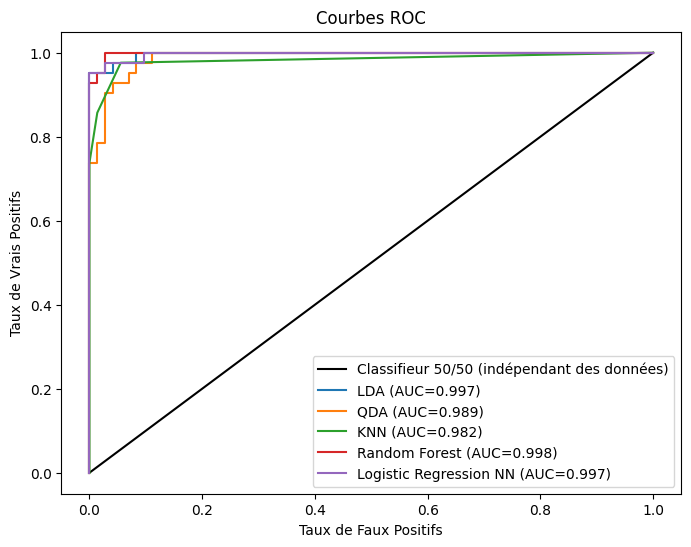

In [109]:
# Comparaison des modèles : Courbes ROC (sans les modèles logistiques sauf Neural Network)
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color="k", label='Classifieur 50/50 (indépendant des données)')

# Modèles à exclure de la comparaison ROC (tous les logistiques sauf Neural Network)
excluded_models = ['Logit_Baseline', 'Logit_NearMiss', 'Logit_SMOTE', 
                   'PCALogit_Baseline', 'PCALogit_NearMiss', 'PCALogit_SMOTE',
                   'Logistic Regression', 'Logistic Regression NN NearMiss'] 

for name, res in results.items():
    # Exclure les modèles logistiques sauf le Neural Network (sans NearMiss)
    if name in excluded_models:
        continue
    
    if 'model' in res:
        model = res['model']
        # Gérer les modèles avec predict_proba (sklearn)
        if hasattr(model, 'predict_proba'):
            if 'y_proba' in res:
                y_pred = res['y_proba']
                # Déterminer le bon y_test selon le type de modèle
                if name == 'Logistic Regression NN':
                    y_true_roc = res.get('y_test', y_test_nn)
                else:
                    y_true_roc = y_test
            else:
                y_pred = model.predict_proba(X_test)[:, 1]
                y_true_roc = y_test
        # Gérer les modèles Keras (neural network)
        elif hasattr(model, 'predict'):
            if 'y_proba' in res:
                y_pred = res['y_proba']
                y_true_roc = res.get('y_test', y_test_nn)
            else:
                y_pred = model.predict(X_test_scaled_nn).flatten()
                y_true_roc = y_test_nn
        else:
            continue
            
        faux_pos, vrai_pos, thresholds = roc_curve(y_true_roc, y_pred)
        plt.plot(faux_pos, vrai_pos, label=name + " (AUC=" + str(np.round(roc_auc_score(y_true_roc, y_pred), 3)) + ")")

plt.title("Courbes ROC")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.legend()
plt.savefig('Courbes ROC.png')
plt.show()


In [112]:
# AUC par algorithme
print("AUC par algorithme : ")
for name, res in results.items():
    if 'model' in res and hasattr(res['model'], 'predict_proba'):
        model = res['model']
        if 'y_proba' in res:
            y_pred = res['y_proba']
            # Déterminer le bon y_test selon le type de modèle
            if name.startswith('PCALogit'):
                y_true = y_test_pca_logit
            elif name.startswith('Logit'):
                y_true = y_test_logit
            else:
                y_true = y_test
        else:
            y_pred = model.predict_proba(X_test)[:, 1]
            y_true = y_test
        print(name + "    " + str(roc_auc_score(y_true, y_pred)))


AUC par algorithme : 
LDA    0.9970238095238095
QDA    0.9887566137566137
Logistic Regression    0.9953703703703705
KNN    0.982473544973545
Random Forest    0.9983465608465608
Logit_Baseline    0.9801587301587302
Logit_NearMiss    0.9976851851851852
Logit_SMOTE    0.9950396825396826
PCALogit_Baseline    0.9970238095238094
PCALogit_NearMiss    0.9973544973544973
PCALogit_SMOTE    0.9970238095238095


In [113]:
# Validation croisée et stockage des scores
from sklearn.model_selection import StratifiedKFold

print("VALIDATION CROISÉE (5 folds):")
cv_scores_roc = {}  # Dictionnaire pour stocker les scores ROC de chaque modèle

for name, res in results.items():
    if name in ['LDA', 'QDA', 'Logistic Regression', 'KNN', 'Random Forest']:
        model = res['model']
        if name == 'KNN':
            cv_model = KNeighborsClassifier(**knn_grid.best_params_)
        elif name == 'Random Forest':
            cv_model = RandomForestClassifier(random_state=rand_st, class_weight='balanced', **rf_grid.best_params_)
        else:
            cv_model = model
        
        acc_scores = cross_val_score(cv_model, X_sd, y, cv=5, scoring='accuracy', n_jobs=-1)
        roc_scores = cross_val_score(cv_model, X_sd, y, cv=5, scoring=make_scorer(roc_auc_score, needs_proba=True), n_jobs=-1)
        cv_scores_roc[name] = roc_scores  # Stocker les scores pour le boxplot
        print(name + ": Accuracy=" + str(round(acc_scores.mean(), 4)) + "+-" + str(round(acc_scores.std(), 4)) + ", ROC-AUC=" + str(round(roc_scores.mean(), 4)) + "+-" + str(round(roc_scores.std(), 4)))

# Validation croisée pour le Neural Network (Keras)
if 'Logistic Regression NN' in results:
    print("")
    print("Validation croisée pour Logistic Regression NN (peut prendre du temps)...")
    
    # Préparer les données
    X_nn = X_features_nn.values.astype(np.float32)
    y_nn_values = y_nn.values.astype(np.float32)
    
    # Standardiser les données
    scaler_nn_cv = StandardScaler()
    X_nn_scaled = scaler_nn_cv.fit_transform(X_nn)
    
    # Validation croisée manuelle pour le neural network
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_st)
    nn_roc_scores = []
    nn_acc_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_nn_scaled, y_nn_values)):
        # Séparer les données pour ce fold
        X_train_fold = X_nn_scaled[train_idx]
        X_val_fold = X_nn_scaled[val_idx]
        y_train_fold = y_nn_values[train_idx].reshape(-1, 1)
        y_val_fold = y_nn_values[val_idx].reshape(-1, 1)
        
        # Créer et entraîner le modèle pour ce fold
        model_nn_fold = Sequential()
        model_nn_fold.add(Dense(1, input_dim=X_nn_scaled.shape[1], activation='sigmoid'))
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
        model_nn_fold.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        # Entraîner avec early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')
        model_nn_fold.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[early_stopping]
        )
        
        # Prédictions et scores
        y_pred_proba_fold = model_nn_fold.predict(X_val_fold, verbose=0).flatten()
        y_pred_binary_fold = (y_pred_proba_fold > 0.5).astype(int)
        
        # Calculer les scores
        acc_fold = accuracy_score(y_val_fold.flatten(), y_pred_binary_fold)
        roc_fold = roc_auc_score(y_val_fold.flatten(), y_pred_proba_fold)
        
        nn_acc_scores.append(acc_fold)
        nn_roc_scores.append(roc_fold)
        
        # Nettoyer la mémoire
        del model_nn_fold
        tf.keras.backend.clear_session()
    
    # Convertir en array numpy pour cohérence
    nn_roc_scores = np.array(nn_roc_scores)
    nn_acc_scores = np.array(nn_acc_scores)
    
    # Stocker les scores
    cv_scores_roc['Logistic Regression NN'] = nn_roc_scores
    
    print("Logistic Regression NN: Accuracy=" + str(round(nn_acc_scores.mean(), 4)) + "+-" + str(round(nn_acc_scores.std(), 4)) + ", ROC-AUC=" + str(round(nn_roc_scores.mean(), 4)) + "+-" + str(round(nn_roc_scores.std(), 4)))


VALIDATION CROISÉE (5 folds):
LDA: Accuracy=0.9596+-0.007, ROC-AUC=0.9913+-0.0087
QDA: Accuracy=0.9578+-0.0102, ROC-AUC=0.9885+-0.0047
Logistic Regression: Accuracy=0.9754+-0.0102, ROC-AUC=0.9951+-0.004
KNN: Accuracy=0.9578+-0.0189, ROC-AUC=0.9843+-0.0113
Random Forest: Accuracy=0.9578+-0.0218, ROC-AUC=0.9902+-0.0088

Validation croisée pour Logistic Regression NN (peut prendre du temps)...
Logistic Regression NN: Accuracy=0.9737+-0.0124, ROC-AUC=0.9962+-0.0056


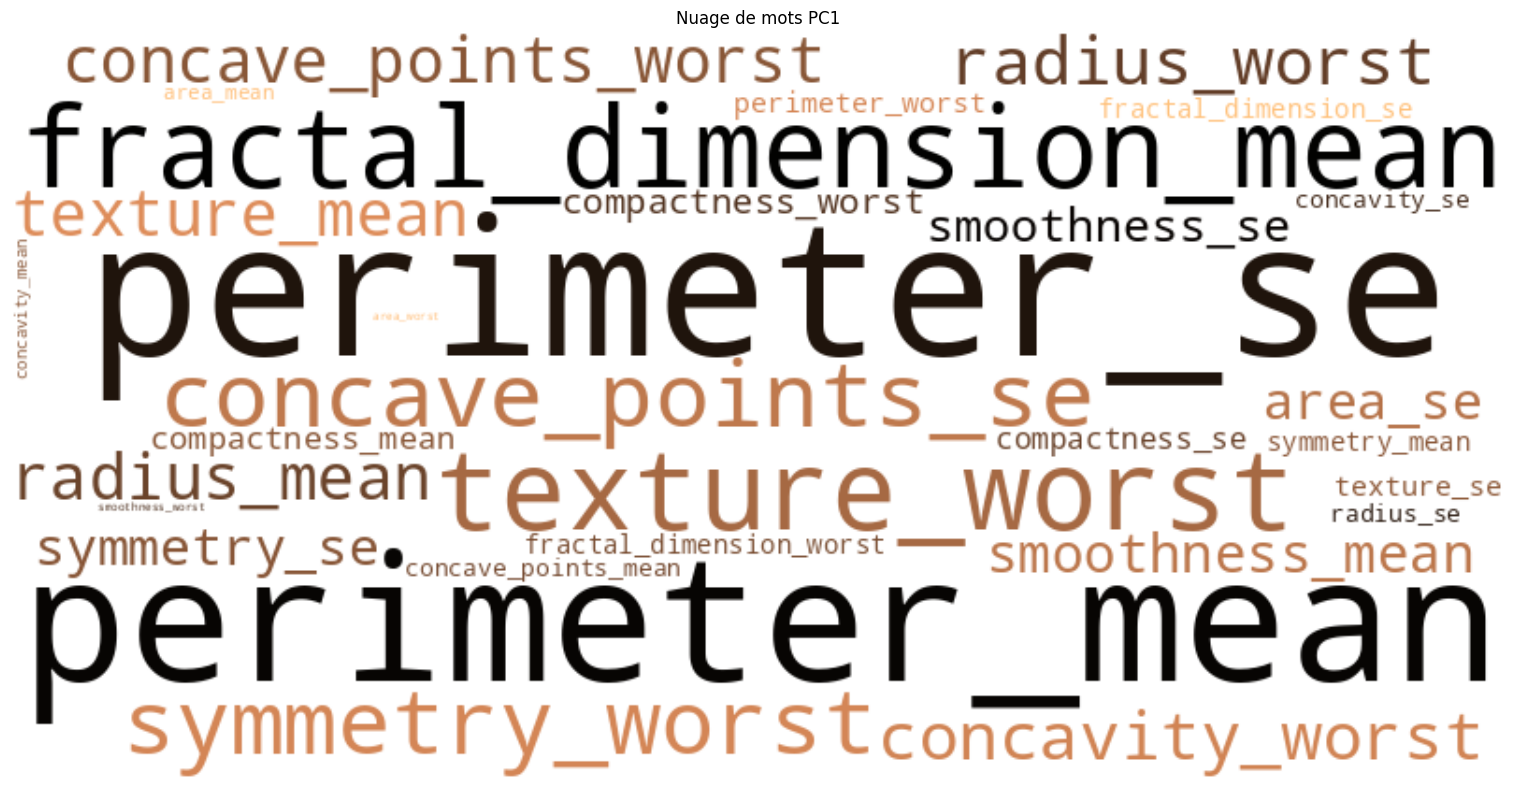

In [104]:
# Nuage de mots pour illustrer les éléments les plus importants du PC1
freq_PC1 = PC_df_val['PC1'].abs().to_dict()
wc_PC1 = WordCloud(width=800, height=400, background_color='white', colormap='copper').generate_from_frequencies(freq_PC1)

plt.figure(figsize=(16, 8))
plt.imshow(wc_PC1, interpolation='bilinear')
plt.title('Nuage de mots PC1')
plt.axis('off')
plt.tight_layout()
plt.savefig('Nuage de mots PC1.png')
plt.show()


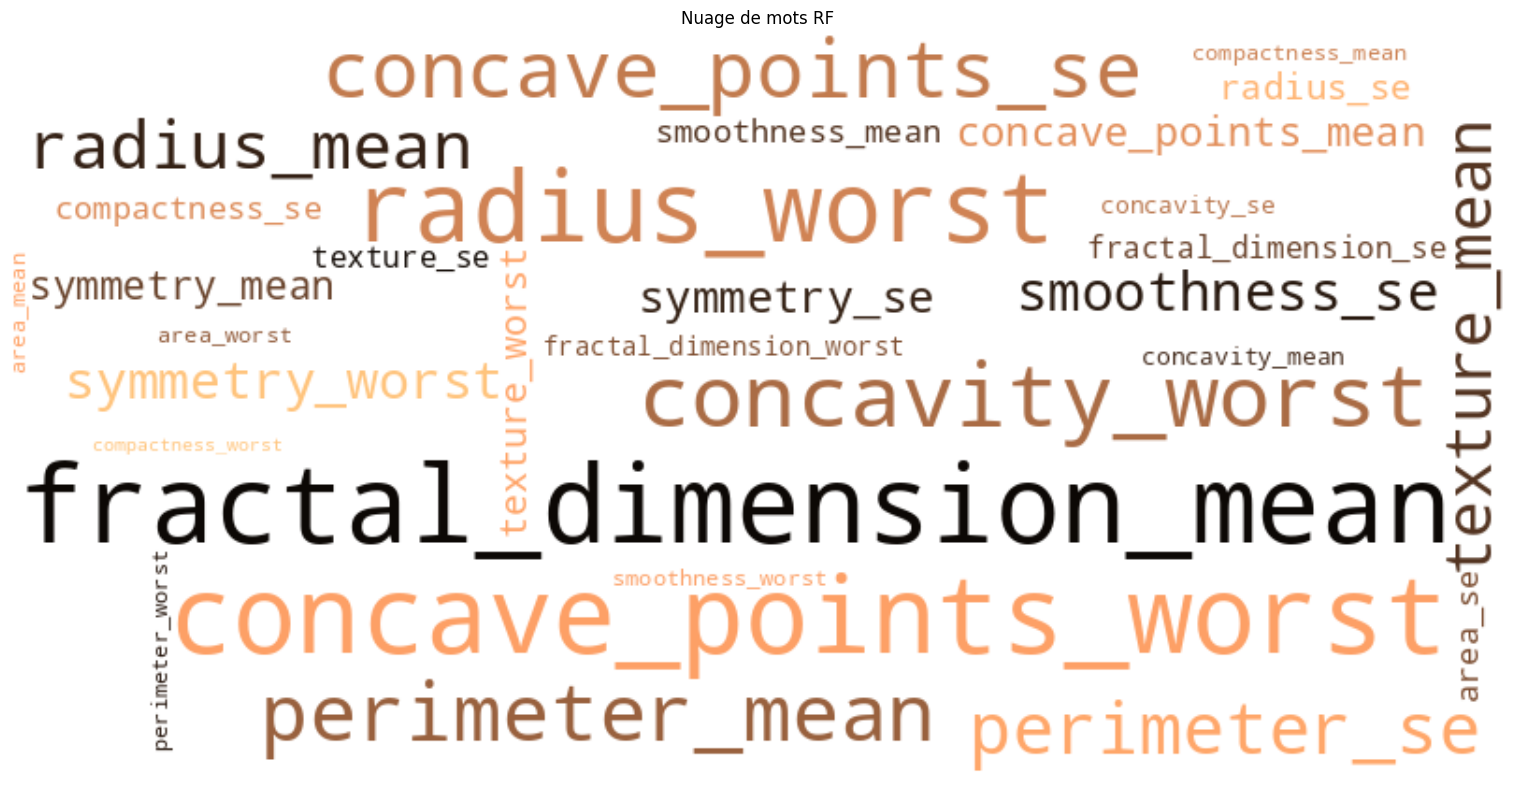

In [105]:
# Nuage de mots pour illustrer les features les plus importantes de RF
wc_RF = WordCloud(width=800, height=400, background_color='white', colormap='copper').generate_from_frequencies(features_importance_rf)
plt.figure(figsize=(16, 8))
plt.imshow(wc_RF, interpolation='bilinear')
plt.title('Nuage de mots RF')
plt.axis('off')
plt.tight_layout()
plt.savefig('Nuage de Mots RF.png')
plt.show()
